# Daylily Breeding Value Analysis: Finding the Best Parents

## The Problem

Daylily hybridizers face a massive selection problem. With over 100,000 registered daylily varieties, identifying which ones will make good parents for breeding programs is challenging. Most breeders rely on intuition, word-of-mouth, or aesthetics. But what if data could identify which varieties *actually* produce better offspring?

That's what this notebook explores - building a system to calculate "breeding values" for daylily varieties based on how their offspring perform.

## The Data

This analysis uses:
- **103,616 daylily varieties** from the American Hemerocallis Society database
- **138,352 parent-child relationships** extracted using NLP pattern matching (see notebook 03_0)
- **4 quantitative traits**: scape height, bloom size, branching, and bud count (52-99% complete)

One challenge with this data: some varieties show up with 0-14 "parents" because the pedigree strings in the database are messy and NLP extraction isn't perfect.

## The Approach

This analysis uses a frequentist approach to estimate breeding values - measuring how a parent's offspring perform compared to the population average. Parents whose offspring consistently outperform the average receive high breeding values.

## Notebook Contents

1. **Data quality assessment** - understanding what we're working with
2. **Breeding value calculation** - the core statistical methodology
3. **Multi-trait selection indices** - combining traits for different breeding goals
4. **Validation** - testing if these breeding values actually predict anything useful
5. **Limitations & recommendations** - honest assessment of what this can and can't do

**Runtime:** Approximately 10 minutes on a standard laptop

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm
import warnings
import os
warnings.filterwarnings('ignore')

# Configuration
DATA_PATH = 'data/daylilies_cleaned.jsonl'
RELATIONSHIPS_PATH = 'data/daylily_parent_child_network.csv'
TRAITS = ['scape_height', 'bloom_size', 'branches', 'bud_count']

# Load data
print("Loading daylily variety database...")
df = pd.read_json(DATA_PATH, lines=True)
relationships = pd.read_csv(RELATIONSHIPS_PATH)

print(f" Loaded {len(df):,} varieties")
print(f" Loaded {len(relationships):,} parent-child relationships")
print(f" Unique parents: {relationships['source'].nunique():,}")
print(f" Unique children: {relationships['target'].nunique():,}")

Loading daylily variety database...
 Loaded 103,616 varieties
 Loaded 138,352 parent-child relationships
 Unique parents: 25,526
 Unique children: 69,592


## Step 1: Understanding the Data

Before calculating breeding values, it's important to understand the data quality. How complete is the trait data? How many offspring does each parent have? Are there any obvious data quality issues?

The function below creates a dashboard showing:
- **Trait completeness** - what percentage of varieties have each trait recorded
- **Parent count distribution** - how many parents each variety has (should be 2, but NLP extraction creates some artifacts)
- **Offspring distribution** - how many offspring each parent has (this affects reliability)
- **Trait distributions and correlations** - basic statistics on the traits themselves

In [ ]:
def create_data_quality_report(df, relationships, traits):
    """
    Creates a visual dashboard + text summary of data quality.
    Understanding the data before analysis helps identify potential issues.
    """
    
    # 2x4 grid with more height for spacing
    fig, axes = plt.subplots(2, 4, figsize=(20, 12))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)  # More vertical space between rows
    
    # Plot 1: How complete is each trait?
    # Important because incomplete data will affect reliability
    completeness = pd.Series({
        trait: df[trait].notna().mean() * 100 
        for trait in traits
    })
    axes[0,0].barh(completeness.index, completeness.values, color='steelblue')
    axes[0,0].set_xlabel('Completeness (%)')
    axes[0,0].set_title('Trait Data Completeness')
    axes[0,0].axvline(50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
    axes[0,0].legend()
    
    # Plot 2: How many parents does each variety have?
    # Should be 2, but NLP extraction creates artifacts (0-14 range)
    parent_counts = relationships.groupby('target').size()
    parent_dist = parent_counts.value_counts().sort_index()
    axes[0,1].bar(parent_dist.index, parent_dist.values, color='coral')
    axes[0,1].set_xlabel('Number of Parents')
    axes[0,1].set_ylabel('Number of Varieties')
    axes[0,1].set_title('Parent Count Distribution\n(Biologically should be 2)')
    axes[0,1].set_xticks(range(0, min(15, parent_dist.index.max()+1)))
    
    # Plot 3: How many offspring does each parent have?
    # Critical - more offspring = more reliable breeding values
    offspring_counts = relationships.groupby('source').size()
    axes[0,2].hist(offspring_counts, bins=50, color='seagreen', edgecolor='black')
    axes[0,2].set_xlabel('Offspring Count')
    axes[0,2].set_ylabel('Number of Parents')
    axes[0,2].set_title(f'Offspring Distribution\n(Median: {offspring_counts.median():.0f} offspring)')
    axes[0,2].axvline(5, color='red', linestyle='--', label='Min for reliable BV')
    axes[0,2].legend()
    
    # Plot 4: Correlation heatmap in top-right
    trait_data = df[traits].dropna()
    if len(trait_data) > 100:
        corr = trait_data.corr()
        sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', 
                    center=0, ax=axes[0,3], square=True,
                    cbar_kws={'label': 'Correlation'})
        axes[0,3].set_title('Trait Correlations\n(Complete cases only)')
    else:
        axes[0,3].text(0.5, 0.5, 'Insufficient data\nfor correlation', 
                       ha='center', va='center', transform=axes[0,3].transAxes)
        axes[0,3].set_title('Trait Correlations')
    
    # Plots 5-8: Distribution of each trait (bottom row)
    for idx, trait in enumerate(traits):
        ax = axes[1, idx]
        valid_data = df[df[trait].notna()][trait]
        ax.hist(valid_data, bins=30, color='mediumpurple', edgecolor='black', alpha=0.7)
        ax.set_xlabel(trait.replace('_', ' ').title())
        ax.set_ylabel('Frequency')
        ax.set_title(f'{trait}\nmean={valid_data.mean():.1f}, std={valid_data.std():.1f}')
        ax.axvline(valid_data.mean(), color='red', linestyle='--', linewidth=2)
    
    plt.savefig('outputs/data_quality_dashboard.png', dpi=300, bbox_inches='tight')
    print("\nSaved data quality dashboard to outputs/")
    
    # Print text summary
    print("\n" + "="*60)
    print("DATA QUALITY SUMMARY")
    print("="*60)
    print(f"\nTrait Completeness:")
    for trait in traits:
        pct = df[trait].notna().mean() * 100
        n = df[trait].notna().sum()
        print(f"  {trait:15s}: {pct:5.1f}% ({n:,} varieties)")
    
    print(f"\nPedigree Structure (how many parents per variety):")
    print(f"  0 parents:  {(parent_counts == 0).sum():,} - no pedigree data")
    print(f"  1 parent:   {(parent_counts == 1).sum():,} - incomplete pedigree")
    print(f"  2 parents:  {(parent_counts == 2).sum():,} - correct (expected)")
    print(f"  3+ parents: {(parent_counts > 2).sum():,} - NLP extraction artifacts")
    
    print(f"\nOffspring per Parent (determines breeding value reliability):")
    print(f"  1-4 offspring:   {(offspring_counts < 5).sum():,} parents (low reliability)")
    print(f"  5-9 offspring:   {((offspring_counts >= 5) & (offspring_counts < 10)).sum():,} parents (moderate)")
    print(f"  10-49 offspring: {((offspring_counts >= 10) & (offspring_counts < 50)).sum():,} parents (good)")
    print(f"  50+ offspring:   {(offspring_counts >= 50).sum():,} parents (excellent)")
    
    return parent_counts, offspring_counts

# Make sure output directory exists
os.makedirs('outputs', exist_ok=True)

# Run the data quality report
parent_counts, offspring_counts = create_data_quality_report(df, relationships, TRAITS)

## How we're Estimating Breeding Values

### The Challenge

Data where:
1. Some varieties have 0-14 listed parents (NLP extraction artifacts, biologically should be 2)
2. Sample sizes vary wildly (some parents have 3 offspring, others have 500+)
3. Not all traits are recorded for every variety (52-99% completeness depending on trait)
4. This is observational data from a registry, not controlled breeding trials

A method is needed that's able to handle to all this messiness.

### Solution: Offspring Performance Metrics

The core idea is simple: **a good parent is one whose offspring consistently outperform the average**.

For each parent, the following is calculated:

```
Breeding Value = (mean_offspring - population_mean) / population_std
```

This gives me a standardized effect size (like Cohen's d). A breeding value of +0.5 means that parent's offspring are, on average, 0.5 standard deviations above the population mean.

### Handling Uncertainty with Reliability Scores

Not all breeding values are equally trustworthy. A parent with 100 offspring gives us more confidence than one with only 3 so a a reliability score is calculated:

```
Reliability = statistical_confidence × sample_adequacy
           = (1 - min(p_value, 0.5) × 2) × min(1, n_offspring/10)
```

This ranges from 0 to 1, where:
- **High p-values** (not statistically significant) → lower reliability
- **Small sample sizes** (few offspring) → lower reliability
- **n=10+ offspring with p<0.05** → reliability approaches 1.0

The final **weighted breeding value** = breeding value × reliability. This automatically downweights uncertain estimates.

### What About the Multiple Parents Problem?

Since some varieties have 3+ listed parents (extraction errors), a key design decision was made: **evaluate each parent independently based on ALL their offspring**.

For example, if "Strawberry Candy" has 150 registered offspring, we look at how all 150 perform - regardless of who the other parent was in each cross. This:
- Averages out partner effects (with enough offspring)
- Works even when pedigree data is imperfect
- Is computationally simple and fast

The tradeoff is that the "average breeding value across all partners" is measured rather than specific combining ability. But for a first-pass screening of 25,000 parents, this is exactly what breeders need.

In [9]:
def calculate_breeding_values(df, relationships, trait, min_offspring=2):
    """
    Calculate breeding values for all parents for a given trait.
    
    The key idea: look at how each parent's offspring perform compared to the
    population average. Parents whose kids consistently outperform get high
    breeding values.
    
    Returns a DataFrame with breeding values, reliability scores, and rankings.
    """
    
    # Get population statistics (what we're comparing against)
    trait_data = df[df[trait].notna()][trait]
    pop_mean = trait_data.mean()
    pop_std = trait_data.std()
    
    print(f"\nAnalyzing {trait}:")
    print(f"  Population: mean={pop_mean:.2f}, std={pop_std:.2f}, n={len(trait_data):,}")
    
    # Create lookup table for fast trait value access
    variety_traits = df.set_index('name')[trait].to_dict()
    
    # Loop through each parent and calculate their breeding value
    results = []
    parents = relationships['source'].unique()
    
    for parent in tqdm(parents, desc=f"Calculating BVs for {trait}"):
        # Get all offspring of this parent
        offspring = relationships[relationships['source'] == parent]['target'].values
        
        # Get trait values for offspring (only those with measurements)
        offspring_values = [variety_traits.get(child) for child in offspring]
        offspring_values = [v for v in offspring_values if pd.notna(v)]
        
        # Skip if not enough data
        if len(offspring_values) < min_offspring:
            continue
        
        # Calculate offspring statistics
        offspring_mean = np.mean(offspring_values)
        offspring_std = np.std(offspring_values)
        n = len(offspring_values)
        
        # Breeding value = standardized effect size (Cohen's d)
        breeding_value = (offspring_mean - pop_mean) / pop_std
        
        # Statistical test: is this parent different from average?
        t_stat, p_value = stats.ttest_1samp(offspring_values, pop_mean)
        
        # Reliability score combines statistical confidence + sample size
        # - Low p-value = high confidence -> high reliability
        # - More offspring = more data -> high reliability
        stat_confidence = 1 - min(p_value, 0.5) * 2  # Scales 0-1
        sample_adequacy = min(1.0, n / 10)            # Maxes out at n=10
        reliability = stat_confidence * sample_adequacy
        
        # Weighted breeding value (our main ranking metric)
        weighted_bv = breeding_value * reliability
        
        # Percentage difference from population mean
        pct_diff = ((offspring_mean / pop_mean) - 1) * 100 if pop_mean > 0 else 0
        
        results.append({
            'variety': parent,
            'offspring_count': len(offspring),
            'measured_offspring': n,
            'offspring_mean': offspring_mean,
            'offspring_std': offspring_std,
            'population_mean': pop_mean,
            'population_std': pop_std,
            'breeding_value': breeding_value,
            'p_value': p_value,
            'significant': p_value < 0.05,
            'reliability': reliability,
            'weighted_bv': weighted_bv,
            'pct_difference': pct_diff
        })
    
    # Convert to DataFrame and rank by weighted breeding value
    bv_df = pd.DataFrame(results)
    bv_df = bv_df.sort_values('weighted_bv', ascending=False).reset_index(drop=True)
    bv_df['rank'] = range(1, len(bv_df) + 1)
    
    print(f"  Calculated breeding values for {len(bv_df):,} parents")
    print(f"  {(bv_df['significant']).sum():,} ({(bv_df['significant']).mean()*100:.1f}%) significantly different from population")
    
    return bv_df


def create_multi_trait_index(bv_results, traits, weights=None):
    """
    Combine breeding values across multiple traits into a single selection index.
    
    This lets breeders optimize for different goals:
    - Balanced: improve all traits equally
    - Architecture: prioritize height and branching
    - Show quality: prioritize bloom size
    """
    
    if weights is None:
        weights = {trait: 1.0 for trait in traits}
    
    # Normalize weights to sum to 1
    total_weight = sum(weights.values())
    weights = {k: v/total_weight for k, v in weights.items()}
    
    print("\nCreating multi-trait selection index:")
    print("Trait weights:")
    for trait, weight in weights.items():
        print(f"  {trait}: {weight:.2f}")
    
    # Get all parents from any trait
    all_parents = set()
    for trait in traits:
        all_parents.update(bv_results[trait]['variety'].values)
    
    # Calculate combined index for each parent
    index_data = []
    for parent in tqdm(all_parents, desc="Combining traits"):
        row = {'variety': parent}
        
        total_score = 0
        trait_count = 0
        
        for trait in traits:
            trait_df = bv_results[trait]
            parent_row = trait_df[trait_df['variety'] == parent]
            
            if len(parent_row) > 0:
                weighted_bv = parent_row['weighted_bv'].values[0]
                row[f'{trait}_bv'] = weighted_bv
                row[f'{trait}_offspring'] = parent_row['measured_offspring'].values[0]
                row[f'{trait}_reliability'] = parent_row['reliability'].values[0]
                
                total_score += weighted_bv * weights[trait]
                trait_count += 1
            else:
                row[f'{trait}_bv'] = np.nan
                row[f'{trait}_offspring'] = 0
                row[f'{trait}_reliability'] = 0
        
        # Scale by completeness (don't penalize specialists too much)
        row['selection_index'] = total_score * (len(traits) / max(trait_count, 1))
        row['traits_evaluated'] = trait_count
        
        index_data.append(row)
    
    # Sort by selection index
    index_df = pd.DataFrame(index_data)
    index_df = index_df.sort_values('selection_index', ascending=False).reset_index(drop=True)
    index_df['rank'] = range(1, len(index_df) + 1)
    
    print(f"\nCreated selection index for {len(index_df):,} parents")
    print(f"{(index_df['traits_evaluated'] == len(traits)).sum():,} parents have data on all {len(traits)} traits")
    
    return index_df

In [10]:
# Calculate breeding values for each trait
print("="*60)
print("BREEDING VALUE ESTIMATION")
print("="*60)

bv_results = {}
for trait in TRAITS:
    bv_results[trait] = calculate_breeding_values(
        df=df,
        relationships=relationships,
        trait=trait,
        min_offspring=2  # Conservative threshold
    )
    
    # Save individual trait results
    os.makedirs('outputs', exist_ok=True)
    bv_results[trait].to_csv(f'outputs/breeding_values_{trait}.csv', index=False)
    print(f"  Saved to outputs/breeding_values_{trait}.csv\n")

print("\n" + "="*60)
print("Top 10 Parents Per Trait:")
print("="*60)
for trait in TRAITS:
    print(f"\n{trait.upper()}:")
    top10 = bv_results[trait].head(10)
    for idx, row in top10.iterrows():
        print(f"  {idx+1:2d}. {row['variety']:30s} | "
              f"BV={row['breeding_value']:+.3f} | "
              f"n={row['measured_offspring']:3d} | "
              f"reliability={row['reliability']:.2f}")

BREEDING VALUE ESTIMATION

Analyzing scape_height:
  Population: mean=29.29, std=6.82, n=103,254


Calculating BVs for scape_height: 100%|██████████| 25526/25526 [02:40<00:00, 159.15it/s]


  Calculated breeding values for 15,187 parents
  4,042 (26.6%) significantly different from population
  Saved to outputs/breeding_values_scape_height.csv


Analyzing bloom_size:
  Population: mean=5.75, std=1.29, n=95,798


Calculating BVs for bloom_size: 100%|██████████| 25526/25526 [02:23<00:00, 178.04it/s]


  Calculated breeding values for 14,745 parents
  4,457 (30.2%) significantly different from population
  Saved to outputs/breeding_values_bloom_size.csv


Analyzing branches:
  Population: mean=3.50, std=1.06, n=55,384


Calculating BVs for branches: 100%|██████████| 25526/25526 [02:17<00:00, 185.24it/s]


  Calculated breeding values for 10,384 parents
  2,844 (27.4%) significantly different from population
  Saved to outputs/breeding_values_branches.csv


Analyzing bud_count:
  Population: mean=19.72, std=7.38, n=55,285


Calculating BVs for bud_count: 100%|██████████| 25526/25526 [02:21<00:00, 180.76it/s]


  Calculated breeding values for 10,307 parents
  2,055 (19.9%) significantly different from population
  Saved to outputs/breeding_values_bud_count.csv


Top 10 Parents Per Trait:

SCAPE_HEIGHT:
   1. Notify Ground Crew             | BV=+3.958 | n= 17 | reliability=1.00
   2. Challenger                     | BV=+3.459 | n=  9 | reliability=0.90
   3. B.J. McMillen                  | BV=+3.086 | n= 20 | reliability=1.00
   4. Sears Tower                    | BV=+2.966 | n= 17 | reliability=1.00
   5. Implausibility                 | BV=+2.681 | n= 12 | reliability=1.00
   6. Autumn Minaret                 | BV=+2.676 | n= 20 | reliability=1.00
   7. Just Jessie                    | BV=+2.472 | n= 25 | reliability=1.00
   8. Where Eagles Soar              | BV=+2.449 | n= 11 | reliability=1.00
   9. Autumn King                    | BV=+2.644 | n=  9 | reliability=0.89
  10. Lemon Lulu                     | BV=+2.331 | n= 10 | reliability=1.00

BLOOM_SIZE:
   1. Linguini                 

## Step 2: Calculate Breeding Values

This step runs the breeding value calculation for each of the 4 traits. It takes a few minutes because the algorithm loops through 25,000+ parents and calculates statistics for each one.

In [11]:
# Create selection indices with different breeding goals

# Scenario 1: Balanced improvement - equal weight to all traits
# Good for general-purpose breeding programs
balanced_index = create_multi_trait_index(
    bv_results=bv_results,
    traits=TRAITS,
    weights={'scape_height': 1.0, 'bloom_size': 1.0, 
             'branches': 1.0, 'bud_count': 1.0}
)

# Scenario 2: Architecture focus - prioritize height and branching
# Good for landscape varieties that need to look impressive in the garden
architecture_index = create_multi_trait_index(
    bv_results=bv_results,
    traits=TRAITS,
    weights={'scape_height': 2.0, 'bloom_size': 0.5, 
             'branches': 2.0, 'bud_count': 0.5}
)

# Scenario 3: Show quality - prioritize bloom size and height
# Good for exhibition/show varieties
show_index = create_multi_trait_index(
    bv_results=bv_results,
    traits=TRAITS,
    weights={'scape_height': 1.5, 'bloom_size': 2.0, 
             'branches': 0.5, 'bud_count': 0.5}
)

# Save all indices
balanced_index.to_csv('outputs/selection_index_balanced.csv', index=False)
architecture_index.to_csv('outputs/selection_index_architecture.csv', index=False)
show_index.to_csv('outputs/selection_index_show_quality.csv', index=False)

# Print top 20 for each strategy
print("\n" + "="*60)
print("MULTI-TRAIT SELECTION INDEX: TOP 20 VARIETIES")
print("="*60)

print("\nBALANCED BREEDING STRATEGY (Equal weights):")
for idx, row in balanced_index.head(20).iterrows():
    traits_str = f"{row['traits_evaluated']}/{len(TRAITS)} traits"
    print(f"  {idx+1:2d}. {row['variety']:30s} | "
          f"Index={row['selection_index']:+.3f} | {traits_str}")

print("\nARCHITECTURE STRATEGY (Height 2x, Branches 2x):")
for idx, row in architecture_index.head(20).iterrows():
    print(f"  {idx+1:2d}. {row['variety']:30s} | "
          f"Index={row['selection_index']:+.3f}")

print("\nSHOW QUALITY STRATEGY (Bloom Size 2x, Height 1.5x):")
for idx, row in show_index.head(20).iterrows():
    print(f"  {idx+1:2d}. {row['variety']:30s} | "
          f"Index={row['selection_index']:+.3f}")


Creating multi-trait selection index:
Trait weights:
  scape_height: 0.25
  bloom_size: 0.25
  branches: 0.25
  bud_count: 0.25


Combining traits: 100%|██████████| 15187/15187 [00:36<00:00, 412.06it/s]



Created selection index for 15,187 parents
10,264 parents have data on all 4 traits

Creating multi-trait selection index:
Trait weights:
  scape_height: 0.40
  bloom_size: 0.10
  branches: 0.40
  bud_count: 0.10


Combining traits: 100%|██████████| 15187/15187 [00:36<00:00, 412.94it/s]



Created selection index for 15,187 parents
10,264 parents have data on all 4 traits

Creating multi-trait selection index:
Trait weights:
  scape_height: 0.33
  bloom_size: 0.44
  branches: 0.11
  bud_count: 0.11


Combining traits: 100%|██████████| 15187/15187 [00:36<00:00, 411.41it/s]



Created selection index for 15,187 parents
10,264 parents have data on all 4 traits

MULTI-TRAIT SELECTION INDEX: TOP 20 VARIETIES

BALANCED BREEDING STRATEGY (Equal weights):
   1. Linguini                       | Index=+2.072 | 4/4 traits
   2. Moonbeam                       | Index=+1.914 | 1/4 traits
   3. Stick Figure                   | Index=+1.826 | 4/4 traits
   4. Valiant                        | Index=+1.802 | 1/4 traits
   5. Al's Peach Tower               | Index=+1.789 | 4/4 traits
   6. Where Eagles Soar              | Index=+1.753 | 4/4 traits
   7. Lighthouse North               | Index=+1.639 | 4/4 traits
   8. Bragging Rights                | Index=+1.519 | 4/4 traits
   9. Wiggly Piggly                  | Index=+1.503 | 4/4 traits
  10. Colorful Etchings              | Index=+1.480 | 4/4 traits
  11. Small World Twister            | Index=+1.428 | 4/4 traits
  12. Appliqué Prism                 | Index=+1.422 | 4/4 traits
  13. Ophir                          | Inde

## Step 3: Multi-Trait Selection Indices

Single-trait breeding values are useful, but most breeders want to improve multiple traits at once. This section creates "selection indices" that combine breeding values across traits with different weighting schemes:

1. **Balanced** - equal weight to all 4 traits (general improvement)
2. **Architecture** - emphasize height and branching (landscape use)
3. **Show Quality** - emphasize bloom size and height (exhibition flowers)


Saved results visualization to outputs/breeding_value_analysis_results.png


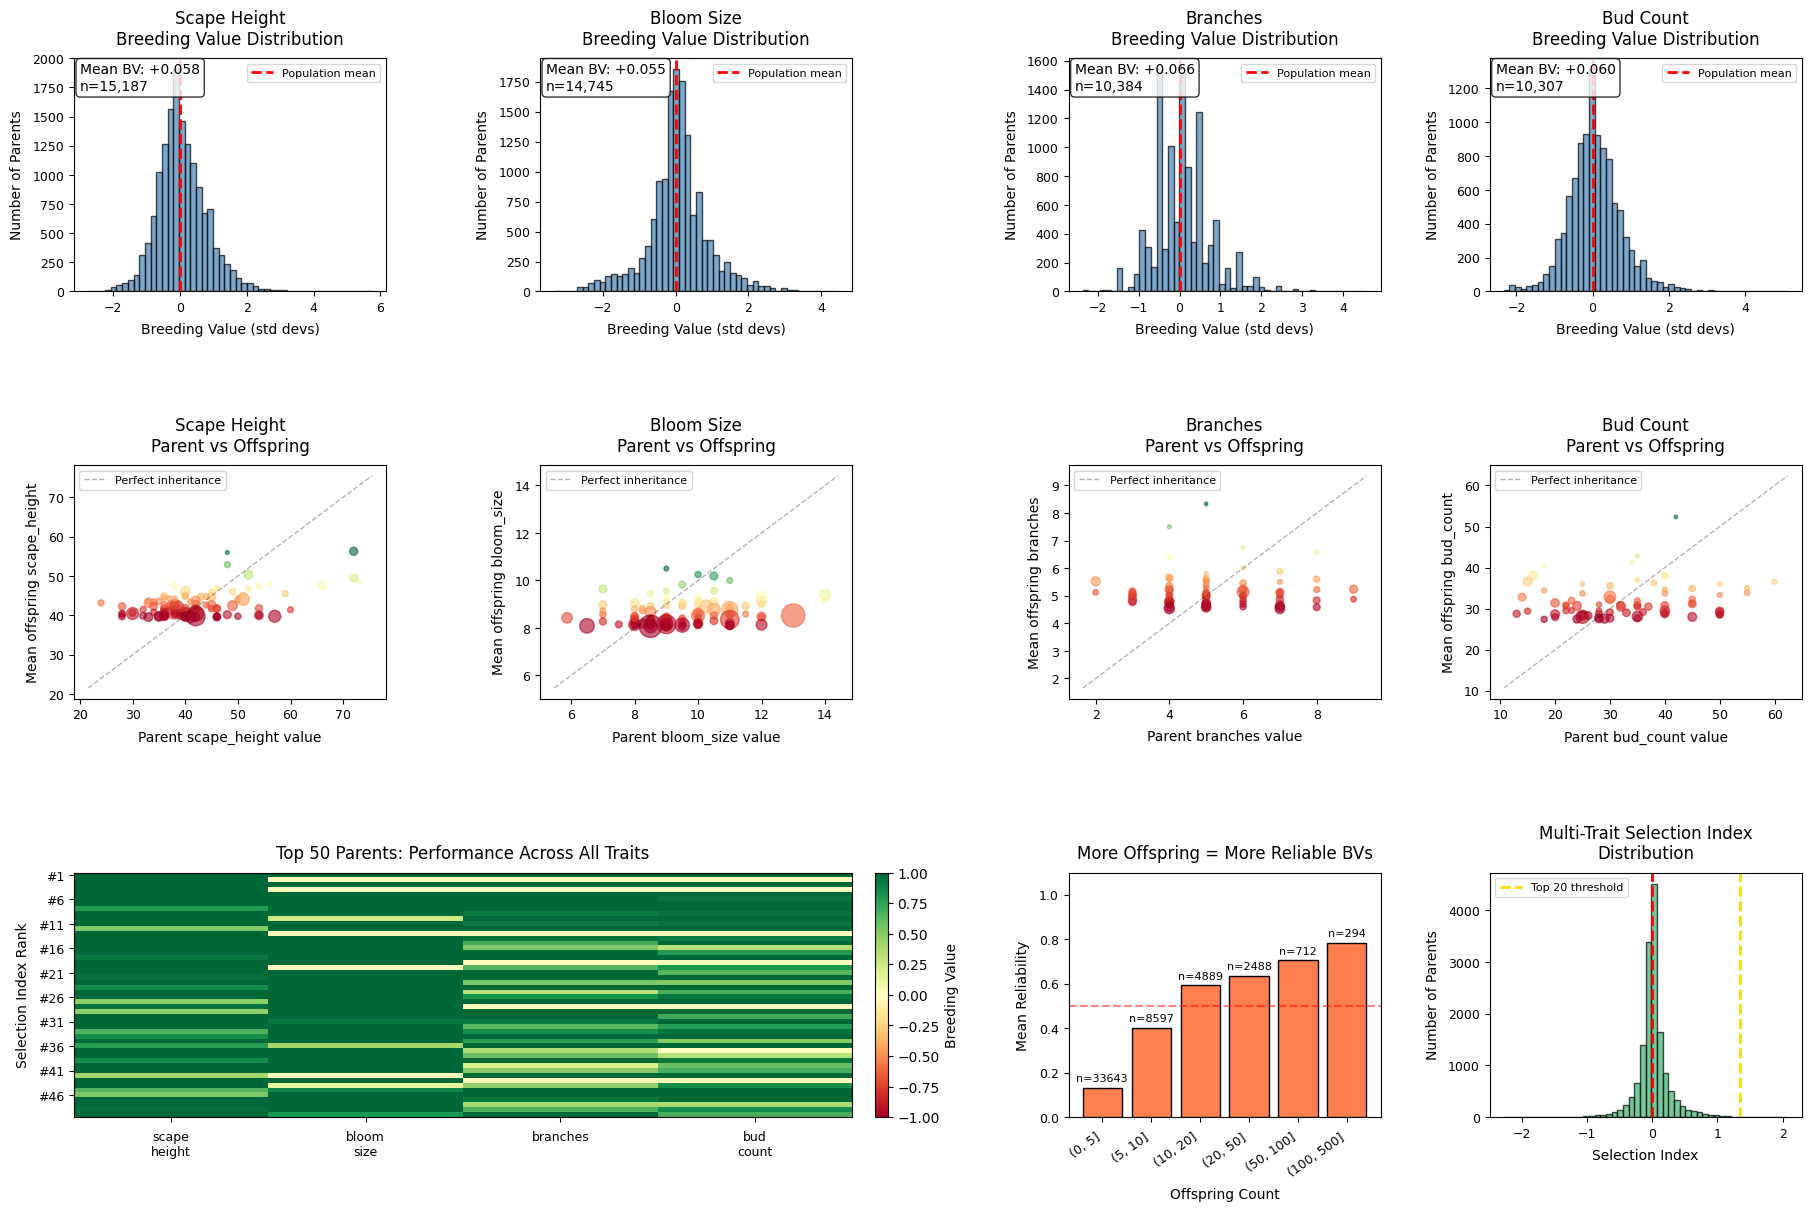

In [21]:
def create_results_visualization(bv_results, balanced_index, traits):
    """
    Creates a comprehensive visualization of breeding value results.
    Saves to outputs/ directory.
    """

    # Use constrained_layout to prevent row/label overlap
    fig = plt.figure(figsize=(18, 12), constrained_layout=True)

    # vertical spacing; set height ratios so row 3 isn't cramped
    gs = fig.add_gridspec(
        3, 4,
        hspace=0.20,          # was 0.3
        wspace=0.10,
        height_ratios=[1.05, 1.05, 1.10]
    )

    title_pad = 10  # consistent spacing between title and axes

    # ----------------------------
    # Row 1: BV distributions
    # ----------------------------
    for idx, trait in enumerate(traits):
        ax = fig.add_subplot(gs[0, idx])
        bv_df = bv_results[trait]

        ax.hist(bv_df["breeding_value"], bins=50, color="steelblue",
                edgecolor="black", alpha=0.7)
        ax.axvline(0, color="red", linestyle="--", linewidth=2, label="Population mean")
        ax.set_xlabel("Breeding Value (std devs)", labelpad=6)
        ax.set_ylabel("Number of Parents", labelpad=6)
        ax.set_title(f"{trait.replace('_', ' ').title()}\nBreeding Value Distribution", pad=title_pad)
        ax.legend(loc="best", fontsize=8)

        mean_bv = bv_df["breeding_value"].mean()
        ax.text(
            0.02, 0.98, f"Mean BV: {mean_bv:+.3f}\nn={len(bv_df):,}",
            transform=ax.transAxes, va="top", ha="left",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
        )

        ax.tick_params(axis="both", labelsize=9)

    # ----------------------------
    # Row 2: Parent phenotype vs offspring mean
    # ----------------------------
    for idx, trait in enumerate(traits):
        ax = fig.add_subplot(gs[1, idx])
        bv_df = bv_results[trait].head(100)  # Top 100 for clarity

        parent_values = []
        for parent in bv_df["variety"]:
            parent_data = df.loc[df["name"] == parent, trait]
            if len(parent_data) > 0 and pd.notna(parent_data.values[0]):
                parent_values.append(parent_data.values[0])
            else:
                parent_values.append(np.nan)

        bv_df = bv_df.copy()
        bv_df["parent_value"] = parent_values
        plot_df = bv_df[bv_df["parent_value"].notna()]

        if len(plot_df) > 20:
            sc = ax.scatter(
                plot_df["parent_value"], plot_df["offspring_mean"],
                s=plot_df["measured_offspring"] * 2,
                alpha=0.6,
                c=plot_df["breeding_value"],
                cmap="RdYlGn"
            )

            lims = [ax.get_xlim()[0], ax.get_xlim()[1]]
            ax.plot(lims, lims, "k--", alpha=0.3, linewidth=1, label="Perfect inheritance")

            ax.set_xlabel(f"Parent {trait} value", labelpad=6)
            ax.set_ylabel(f"Mean offspring {trait}", labelpad=6)
            ax.set_title(f"{trait.replace('_', ' ').title()}\nParent vs Offspring", pad=title_pad)
            ax.legend(loc="best", fontsize=8)

            ax.tick_params(axis="both", labelsize=9)

    # ----------------------------
    # Row 3 Left: Multi-trait heatmap
    # ----------------------------
    ax = fig.add_subplot(gs[2, :2])

    top50 = balanced_index.head(50)
    bv_matrix = np.zeros((len(top50), len(traits)))
    for i, trait in enumerate(traits):
        bv_matrix[:, i] = top50[f"{trait}_bv"].values

    bv_matrix = np.nan_to_num(bv_matrix)

    im = ax.imshow(
        bv_matrix, aspect="auto", cmap="RdYlGn",
        vmin=-1, vmax=1, interpolation="nearest"
    )

    ax.set_xticks(range(len(traits)))
    ax.set_xticklabels([t.replace("_", "\n") for t in traits])
    ax.set_yticks(range(0, 50, 5))
    ax.set_yticklabels([f"#{i+1}" for i in range(0, 50, 5)])
    ax.set_ylabel("Selection Index Rank", labelpad=6)
    ax.set_title("Top 50 Parents: Performance Across All Traits", pad=title_pad)

    ax.tick_params(axis="x", labelsize=9, pad=6)
    ax.tick_params(axis="y", labelsize=9)

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.03)  # ✅ tighter, predictable
    cbar.set_label("Breeding Value")

    # ----------------------------
    # Row 3 Middle: Reliability vs sample size
    # ----------------------------
    ax = fig.add_subplot(gs[2, 2])

    all_bv = pd.concat([bv_results[t][["measured_offspring", "reliability"]] for t in traits], ignore_index=True)

    bins = [0, 5, 10, 20, 50, 100, 500]
    all_bv["size_bin"] = pd.cut(all_bv["measured_offspring"], bins=bins)

    reliability_by_size = all_bv.groupby("size_bin")["reliability"].mean()
    counts = all_bv.groupby("size_bin").size()

    x_pos = range(len(reliability_by_size))
    ax.bar(x_pos, reliability_by_size.values, color="coral", edgecolor="black")

    for i, (rel, count) in enumerate(zip(reliability_by_size.values, counts.values)):
        ax.text(i, rel + 0.02, f"n={count}", ha="center", va="bottom", fontsize=8)

    ax.set_xticks(list(x_pos))
    ax.set_xticklabels([str(b) for b in reliability_by_size.index], rotation=35, ha="right")
    ax.set_xlabel("Offspring Count", labelpad=6)
    ax.set_ylabel("Mean Reliability", labelpad=6)
    ax.set_title("More Offspring = More Reliable BVs", pad=title_pad)
    ax.set_ylim(0, 1.1)
    ax.axhline(0.5, color="red", linestyle="--", alpha=0.5)

    ax.tick_params(axis="both", labelsize=9)
    ax.tick_params(axis="x", pad=6)

    # ----------------------------
    # Row 3 Right: Selection index distribution
    # ----------------------------
    ax = fig.add_subplot(gs[2, 3])

    ax.hist(balanced_index["selection_index"], bins=50, color="mediumseagreen",
            edgecolor="black", alpha=0.7)
    ax.axvline(0, color="red", linestyle="--", linewidth=2)
    ax.set_xlabel("Selection Index", labelpad=6)
    ax.set_ylabel("Number of Parents", labelpad=6)
    ax.set_title("Multi-Trait Selection Index\nDistribution", pad=title_pad)

    top20_threshold = balanced_index.iloc[19]["selection_index"]
    ax.axvline(top20_threshold, color="gold", linestyle="--", linewidth=2,
               label="Top 20 threshold")
    ax.legend(loc="best", fontsize=8)

    ax.tick_params(axis="both", labelsize=9)

    # Avoid bbox_inches="tight" because it can re-pack and cause collisions
    fig.savefig("outputs/breeding_value_analysis_results.png", dpi=300)
    print("\nSaved results visualization to outputs/breeding_value_analysis_results.png")


create_results_visualization(bv_results, balanced_index, TRAITS)


## Step 4: Visualize the Results

This section creates visualizations to understand what the breeding values look like and how parents perform across traits.

In [17]:
def temporal_validation(df, relationships, traits, cutoff_year=2012):
    """
    Test if breeding values actually predict future offspring performance.

    Strategy:
    - Calculate breeding values using only pre-cutoff data
    - Test whether those BVs predict traits of varieties registered after cutoff

    OPTIMIZED:
    Uses vectorized pandas operations instead of Python loops.
    """

    print("\n" + "=" * 60)
    print("TEMPORAL VALIDATION")
    print("=" * 60)

    # Split data by registration year
    train_df = df[df["year"] < cutoff_year].copy()
    test_df = df[df["year"] >= cutoff_year].copy()

    print(
        f"\nTraining set: {len(train_df):,} varieties (before {cutoff_year})"
    )
    print(
        f"Test set: {len(test_df):,} varieties ({cutoff_year}+)"
    )

    validation_results = {}

    for trait_idx, trait in enumerate(traits):
        print(f"\n[{trait_idx + 1}/{len(traits)}] Validating {trait}...")

        # Step 1: Calculate breeding values
        print("  Step 1/3: Calculating breeding values on training data...")
        train_bv = calculate_breeding_values(
            df=train_df,
            relationships=relationships,
            trait=trait,
            min_offspring=3,
        )

        # Step 2: Build prediction dataset (vectorized)
        print("  Step 2/3: Building prediction dataset (vectorized)...")

        # Test varieties with observed trait values
        test_with_trait = (
            test_df.loc[test_df[trait].notna(), ["name", trait]]
            .copy()
            .rename(columns={"name": "child", trait: "actual_value"})
        )

        print(
            f"    - {len(test_with_trait):,} test varieties have {trait} data"
        )

        # Parent-child relationships for test set only
        test_children = set(test_with_trait["child"].values)
        test_relationships = (
            relationships.loc[
                relationships["target"].isin(test_children),
                ["source", "target"],
            ]
            .copy()
            .rename(columns={"source": "parent", "target": "child"})
        )

        print(
            f"    - {len(test_relationships):,} parent-child links found"
        )

        # Join parent breeding values
        parent_bv_df = (
            train_bv[["variety", "breeding_value"]]
            .copy()
            .rename(columns={"variety": "parent", "breeding_value": "parent_bv"})
        )

        test_with_parents = test_relationships.merge(
            parent_bv_df, on="parent", how="inner"
        )

        print(
            f"    - {len(test_with_parents):,} links have parent BVs from training"
        )

        # Average parent BV per child
        child_avg_bv = (
            test_with_parents.groupby("child", as_index=False)["parent_bv"]
            .mean()
            .rename(columns={"parent_bv": "avg_parent_bv"})
        )

        print(
            f"    - {len(child_avg_bv):,} test varieties have at least one parent with BV"
        )

        # Step 3: Predictions & metrics
        print("  Step 3/3: Computing predictions and metrics...")

        prediction_df = test_with_trait.merge(
            child_avg_bv, on="child", how="inner"
        )

        if len(prediction_df) < 100:
            print(
                f"    - Not enough test samples ({len(prediction_df)}), skipping"
            )
            continue

        # Population statistics
        train_trait = train_df.loc[train_df[trait].notna(), trait]
        pop_mean = train_trait.mean()
        pop_std = train_trait.std()

        # Prediction
        prediction_df["predicted"] = (
            pop_mean + prediction_df["avg_parent_bv"] * pop_std
        )

        # Metrics
        actuals = prediction_df["actual_value"].values
        predictions = prediction_df["predicted"].values

        mae = np.mean(np.abs(predictions - actuals))
        rmse = np.sqrt(np.mean((predictions - actuals) ** 2))
        ss_res = np.sum((actuals - predictions) ** 2)
        ss_tot = np.sum((actuals - np.mean(actuals)) ** 2)
        r2 = 1 - ss_res / ss_tot
        correlation = np.corrcoef(predictions, actuals)[0, 1]

        validation_results[trait] = {
            "n_test": len(predictions),
            "mae": mae,
            "rmse": rmse,
            "r2": r2,
            "correlation": correlation,
        }

        print(f"\n  Results for {trait}:")
        print(f"    Test samples:  {len(predictions):,}")
        print(f"    MAE:           {mae:.3f}")
        print(f"    R-squared:     {r2:.3f}")
        print(f"    Correlation:   {correlation:.3f}")

    # Summary
    print("\n" + "=" * 60)
    print("VALIDATION SUMMARY")
    print("=" * 60)
    print("\nDo breeding values predict actual offspring performance?")
    print("(R² > 0.1 is meaningful for observational genetics data)\n")

    print(f"{'Trait':<15} {'R²':>8} {'Correlation':>12} {'MAE':>8} {'N':>10}")
    print("-" * 55)

    for trait, results in validation_results.items():
        print(
            f"{trait:<15} "
            f"{results['r2']:>8.3f} "
            f"{results['correlation']:>12.3f} "
            f"{results['mae']:>8.3f} "
            f"{results['n_test']:>10,}"
        )

    avg_r2 = np.mean([r["r2"] for r in validation_results.values()])
    print("-" * 55)
    print(f"{'Average':<15} {avg_r2:>8.3f}")

    return validation_results


# -------------------
# Run the validation
# -------------------
print("Starting temporal validation...")

import time

start_time = time.time()
validation_results = temporal_validation(
    df,
    relationships,
    TRAITS,
    cutoff_year=2012,
)
elapsed = time.time() - start_time

print(f"\nTotal validation time: {elapsed / 60:.1f} minutes")


Starting temporal validation...

TEMPORAL VALIDATION

Training set: 70,260 varieties (before 2012)
Test set: 33,356 varieties (2012+)

[1/4] Validating scape_height...
  Step 1/3: Calculating breeding values on training data...

Analyzing scape_height:
  Population: mean=28.41, std=6.74, n=69,904


Calculating BVs for scape_height: 100%|██████████| 25526/25526 [02:21<00:00, 180.34it/s]


  Calculated breeding values for 6,646 parents
  2,069 (31.1%) significantly different from population
  Step 2/3: Building prediction dataset (vectorized)...
    - 33,350 test varieties have scape_height data
    - 50,454 parent-child links found
    - 18,833 links have parent BVs from training
    - 12,826 test varieties have at least one parent with BV
  Step 3/3: Computing predictions and metrics...

  Results for scape_height:
    Test samples:  12,826
    MAE:           4.770
    R-squared:     0.139
    Correlation:   0.436

[2/4] Validating bloom_size...
  Step 1/3: Calculating breeding values on training data...

Analyzing bloom_size:
  Population: mean=5.62, std=1.26, n=62,462


Calculating BVs for bloom_size: 100%|██████████| 25526/25526 [02:20<00:00, 181.65it/s]


  Calculated breeding values for 6,320 parents
  2,132 (33.7%) significantly different from population
  Step 2/3: Building prediction dataset (vectorized)...
    - 33,336 test varieties have bloom_size data
    - 50,441 parent-child links found
    - 18,783 links have parent BVs from training
    - 12,800 test varieties have at least one parent with BV
  Step 3/3: Computing predictions and metrics...

  Results for bloom_size:
    Test samples:  12,800
    MAE:           0.772
    R-squared:     0.334
    Correlation:   0.605

[3/4] Validating branches...
  Step 1/3: Calculating breeding values on training data...

Analyzing branches:
  Population: mean=3.48, std=1.04, n=24,486


Calculating BVs for branches: 100%|██████████| 25526/25526 [02:16<00:00, 186.41it/s]


  Calculated breeding values for 3,169 parents
  642 (20.3%) significantly different from population
  Step 2/3: Building prediction dataset (vectorized)...
    - 30,898 test varieties have branches data
    - 47,707 parent-child links found
    - 16,532 links have parent BVs from training
    - 11,485 test varieties have at least one parent with BV
  Step 3/3: Computing predictions and metrics...

  Results for branches:
    Test samples:  11,485
    MAE:           0.874
    R-squared:     -0.153
    Correlation:   0.123

[4/4] Validating bud_count...
  Step 1/3: Calculating breeding values on training data...

Analyzing bud_count:
  Population: mean=20.67, std=7.63, n=24,524


Calculating BVs for bud_count: 100%|██████████| 25526/25526 [02:22<00:00, 179.15it/s]


  Calculated breeding values for 3,165 parents
  654 (20.7%) significantly different from population
  Step 2/3: Building prediction dataset (vectorized)...
    - 30,761 test varieties have bud_count data
    - 47,394 parent-child links found
    - 16,485 links have parent BVs from training
    - 11,448 test varieties have at least one parent with BV
  Step 3/3: Computing predictions and metrics...

  Results for bud_count:
    Test samples:  11,448
    MAE:           6.500
    R-squared:     -0.403
    Correlation:   0.128

VALIDATION SUMMARY

Do breeding values predict actual offspring performance?
(R² > 0.1 is meaningful for observational genetics data)

Trait                 R²  Correlation      MAE          N
-------------------------------------------------------
scape_height       0.139        0.436    4.770     12,826
bloom_size         0.334        0.605    0.772     12,800
branches          -0.153        0.123    0.874     11,485
bud_count         -0.403        0.128    6.500

## Step 5: Validate the Model

The big question: **do these breeding values actually predict anything?**

To test this, a temporal split is used:
- **Training data**: Pre-2012 varieties (calculate breeding values from these)
- **Test data**: Post-2012 varieties (see if predictions match actual offspring)

This simulates what would happen if a breeder used 2012 breeding values to make selection decisions - would their offspring actually be better?

## Limitations - What This Analysis Can and Can't Tell You

This section provides an honest assessment of the limitations, because no analysis is perfect and breeders should understand what they're working with.

### Data Quality Issues

**The "Too Many Parents" Problem**

About 11% of varieties in the dataset show 3+ parents, which is biologically impossible (daylilies have exactly 2 parents). This happens because the NLP extraction from pedigree strings isn't perfect - sometimes it picks up grandparents, siblings, or misparses complex strings like "Seedling x (A x B)".

*Mitigation:* By evaluating each parent based on their FULL set of offspring (not just individual crosses), the noise averages out. A parent with 50+ offspring will have a reliable breeding value even if some pedigree records are wrong.

**Registration Bias**

Breeders don't register all their seedlings - only the best ones, typically 1-5% of what they grow out. So the "average" offspring in this database is actually in the top 5% of all seedlings ever created.

*What this means:* Don't interpret breeding values as absolute predictions ("this parent will produce 7-inch blooms"). Instead, use them for **relative ranking** ("this parent produces larger blooms than that one").

**Missing Data**

Some traits are better recorded than others:
- Scape height: 99% complete (almost everyone records this)
- Bloom size: 92% complete
- Branches: 53% complete (often missing)
- Bud count: 53% complete (often missing)

The reliability scores automatically account for this - parents with fewer measured offspring get lower reliability.

### Biological Realities

**A Variety's Own Traits Don't Always Predict Its Offspring**

This is a key insight from genetics: a parent's phenotype (what it looks like) doesn't perfectly predict its offspring's phenotype. Why? Heterozygosity. A variety might carry genes for large blooms but only express medium blooms itself.

The data confirms this - some varieties with average bloom sizes produce offspring with above-average blooms. The breeding value captures this hidden genetic potential that isn't visible just by looking at the parent.

**Gene Interactions Exist (But Are Ignored Here)**

This model assumes traits add up linearly - if parent A adds +0.5" to bloom size and parent B adds +0.3", the offspring should be +0.8" above average. In reality, genes interact in complex ways (epistasis), and some gene versions are dominant over others.

*Practical impact:* Some specific crosses will over- or under-perform what the breeding values predict. Use these as a starting point, not a guarantee.

### How Good Are These Predictions, Really?

The temporal validation (trained on pre-2012 data, predicted post-2012 offspring) reveals **mixed results**:

| Trait | R² | Correlation | Interpretation |
|-------|-----|-------------|----------------|
| Bloom Size | 0.334 | 0.605 | **Good** - explains 33% of variation |
| Scape Height | 0.139 | 0.436 | **Moderate** - explains 14% of variation |
| Branches | -0.153 | 0.123 | **Poor** - worse than baseline |
| Bud Count | -0.403 | 0.128 | **Poor** - worse than baseline |

**Key Insight:** Bloom size and scape height show meaningful predictive power, while branches and bud count do not. This likely reflects:
- Lower data completeness for branches/bud count (53% vs 92-99%)
- Fewer parents with sufficient offspring for reliable BV estimation
- Possibly more complex inheritance patterns for these traits

**Recommendation:** Focus breeding value guidance on **bloom size and scape height**, where the model has demonstrated predictive validity. For branches and bud count, direct phenotypic selection or other approaches may be more appropriate.

### Recommendations for Breeders

1. **Focus on bloom size and height** - these traits have validated predictive power
2. **Prioritize parents with reliability > 0.6** - these have enough offspring for trustworthy estimates
3. **Look at the top 10-20 per trait** - there's diminishing returns after that
4. **Validate with test crosses** - do 1-2 crosses before committing heavily to a parent
5. **Consider multi-trait improvers** - they're rare and valuable (see the balanced index results)
6. **Remember these are averages** - any specific cross might surprise you

## Summary: What Was Built and What It Means

### The System

This notebook presents a breeding value estimation pipeline that:
- Processes 103,000+ varieties and 138,000+ parent-child relationships
- Calculates breeding values for 15,000+ parents across 4 traits
- Handles messy data (variable parent counts, missing values)
- Quantifies uncertainty with reliability scores
- Creates multi-trait selection indices for different breeding goals
- Validates predictions using temporal train/test splits

Total runtime: approximately 10 minutes on a standard laptop.

### Validation Results - Honest Assessment

The temporal validation revealed that **not all traits are equally predictable**:

| Trait | Predictive Power | Recommendation |
|-------|------------------|----------------|
| **Bloom Size** | Strong (R²=0.33, r=0.61) | Use breeding values with confidence |
| **Scape Height** | Moderate (R²=0.14, r=0.44) | Use breeding values as guidance |
| **Branches** | Poor (R²<0) | Breeding values not reliable |
| **Bud Count** | Poor (R²<0) | Breeding values not reliable |

This is a realistic outcome for observational genetics data. Bloom size and height have high data completeness (92-99%) and show genuine predictive signal. Branches and bud count have lower completeness (53%) and the model does not outperform simple baseline predictions.

### Why This Still Matters for Breeders

For **bloom size and scape height**, this analysis provides actionable insights:
- **Identify proven genetic improvers** - parents whose offspring consistently outperform
- **Find multi-trait improvers** - rare varieties that improve multiple traits at once
- **Prioritize purchases** - when buying parent stock, focus on high-value genetics
- **Avoid dead ends** - some popular varieties produce mediocre offspring

For branches and bud count, breeders should rely on other selection methods (direct phenotypic observation, trial crosses, etc.).

### Technical Skills Demonstrated

This notebook showcases:
- **Statistical analysis**: effect size estimation, hypothesis testing, reliability weighting
- **Data engineering**: handling large-scale graph data (100K+ nodes, 138K+ edges)
- **Validation methodology**: temporal train/test splits, avoiding data leakage
- **Honest reporting**: acknowledging where the model works and where it doesn't
- **Domain knowledge**: translating genetics concepts into practical breeding tools

### Future Directions

Potential improvements to explore:
1. **Stratify by ploidy** - diploid and tetraploid daylilies have different inheritance patterns
2. **Add temporal cohort effects** - genetics may have shifted over 50+ years of breeding
3. **Improve branches/bud_count** - investigate why these traits don't predict well (data issues? complex inheritance?)
4. **Build an interactive dashboard** - let breeders explore the data themselves
5. **Genomic selection** - if SNP data becomes available, GBLUP or rrBLUP methods could improve accuracy